# GAN experiment

## Imports + mount google drive (if colab)


In [2]:
# imports
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    output_path = "/content/drive/My Drive/gan_files"
    %rm -r /content/BP-Bielko-GAN-Docker
    %rm -r /content/src
    !git clone https://github.com/2021-FIIT-Bc-projects/BP-Bielko-GAN-Docker.git
    %cd BP-Bielko-GAN-Docker/gan
else:
    output_path = "."


from src.dcgan_models import *

In [90]:
list_physical_devices('GPU') # checking if colab has gpu included, does not work for local machine

NameError: name 'list_physical_devices' is not defined

## Downloading the Flickr-Faces-HQ dataset
Option A: Download the dataset from scratch - high probability of google limiting download quota (if colab)

Option B: Load prepared copy of the dataset from google drive

In [ ]:
# A
# %cd /content/
!git clone https://github.com/NVlabs/ffhq-dataset.git
%cd ffhq-dataset
!python download_ffhq.py --thumbs

In [ ]:
# B
!mkdir /content/ffhq-dataset
!unzip "/content/drive/MyDrive/ffhq_dataset_thumbs/dataset_download.zip" -d "dataset_download"

In [ ]:
# C - AVATAR


## Creating the model

In [3]:
# model definitions

model_name = "gan_128_final_strong"

p_dims = 100
p_n = 100
predetermined_inputs = np.random.randn(p_dims * p_n)  # n vectors from the normal distribution
predetermined_inputs = predetermined_inputs.reshape(p_n, p_dims)

height = 128
width = 128

generator = Generator(height, width, n_dim=100, n_paralell_samples=128, init_size=4)
discriminator = Discriminator(height, width, n_filters=256, dataset_path="dataset_download/thumbnails128x128")

gan = GAN(generator, discriminator, height=height, width=width, model_name=model_name, output_path=output_path)


2022-05-16 17:19:51.697384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 17:19:51.703915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 17:19:51.704576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 17:19:51.705633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Traiting process

In [ ]:
metadata_list = []

from_epoch = 0
to_epoch = 2

dataset_size = 70000

a = datetime.datetime.now()

gan.train_gan(dataset_size, metadata_list,
                n_dim=100, start_epoch=from_epoch, n_epochs=to_epoch,
                n_batch=dataset_size//700, n_eval=50, eval_samples=100, n_plot=50, plot_size=9)

b = datetime.datetime.now()
print("Time taken: ", b - a)

generator.model.save_weights(f"{output_path}/{model_name}/saves/generator_{to_epoch}.hdf5", overwrite=True)
discriminator.model.save_weights(f"{output_path}/{model_name}/saves/discriminator_{to_epoch}.hdf5", overwrite=True)

In [ ]:
print(generator.model.summary())
#print(discriminator.model.summary())

NameError: ignored

## Load specific epoch of this model name

In [4]:
load_epoch = 270
generator.model.load_weights(f"{output_path}/{model_name}/saves/generator_{load_epoch}")
discriminator.model.load_weights(f"{output_path}/{model_name}/saves/discriminator_{load_epoch}")

In [ ]:
compiled_generator = Generator(height, width, n_dim=100, n_paralell_samples=128, init_size=4)
compiled_generator.model.load_weights(f"{output_path}/{model_name}/saves/generator_{4}.hdf5")

adam = Adam(lr=0.0002, beta_1=0.5)
compiled_generator.model.compile(loss='binary_crossentropy', optimizer=adam)  # metrics kvoli evaluation

print(compiled_generator.model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 2048)              206848    
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_6 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_29 (Conv2D  (None, 8, 8, 128)        262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_30 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Generate a collage of samples from inputs

2022-05-16 17:36:01.082825: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-16 17:36:01.530215: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-05-16 17:36:01.745868: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


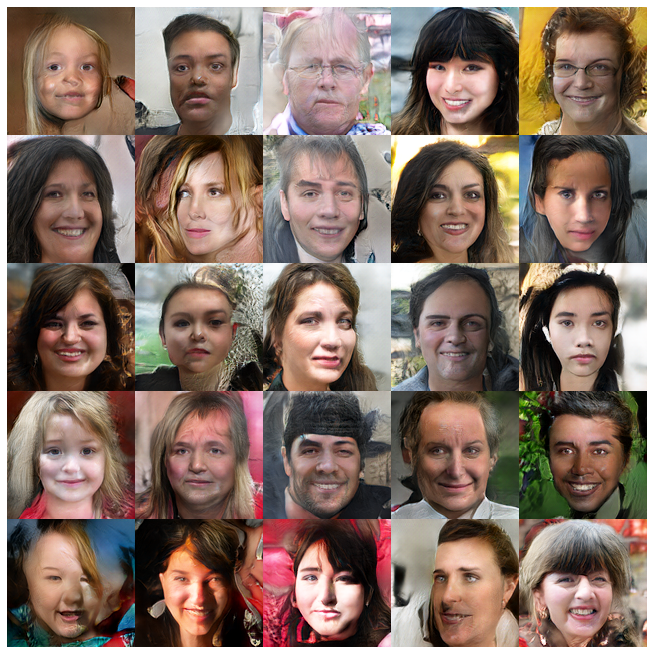

Time taken:  0:00:01.941262


In [5]:
a = datetime.datetime.now()
plot = generate_and_plot(generator, 100, predetermined_inputs, 25)
b = datetime.datetime.now()

plt.show()


print("Time taken: ", b - a)

In [6]:
import imageio

def make_anim(generator, inputs, A_index, B_index, steps, scale=1, n_dim=100):
    A = inputs[A_index]
    B = inputs[B_index]
    transition_points = latent_transition(A, B, n_dim=n_dim, n_steps=steps)

    X_output, _ = generator.generate_fake_samples(transition_points, n_dim, steps)

    outputs = float_to_rgb(X_output)
    scaled = outputs.repeat(scale, axis=1).repeat(scale, axis=2)

    images = [output for output in scaled]

    imageio.mimsave(f'anim_{A_index}_{B_index}.gif', images, duration=0.05)
    print("done")


In [38]:
import imageio

def make_child(generator, inputs, A_index, B_index, scale=1, n_dim=100):
    A = inputs[A_index]
    B = inputs[B_index]
    middle_point = np.empty([1, n_dim])
    middle_point[0] = (A - B) * 0.5 + A

    X_output, _ = generator.generate_fake_samples([middle_point], n_dim, 1)

    outputs = float_to_rgb(X_output)
    scaled = outputs.repeat(scale, axis=1).repeat(scale, axis=2)

    imageio.mimsave(f'child_{A_index}_{B_index}.png', scaled, duration=0.05)
    print("done")

In [7]:
a = datetime.datetime.now()
make_anim(generator, predetermined_inputs, 3, 15, 5, scale=3)
b = datetime.datetime.now()
print("Time taken: ", b - a)

done
Time taken:  0:00:00.293500


In [6]:
make_child(generator, predetermined_inputs, 11, 5, scale=1)

NameError: name 'make_child' is not defined

## Generate random samples with given diversity

In [8]:
def fastRandomPointFromDistance(origin, distance, n_dims):
    distance_squared = distance ** 2
    a = np.random.uniform(size=n_dims)
    a /= sum(a)
    a *= distance_squared
    a = np.sqrt(a)
    for i, coord in enumerate(a):
        a[i] *= np.random.choice([1, -1])
    return a

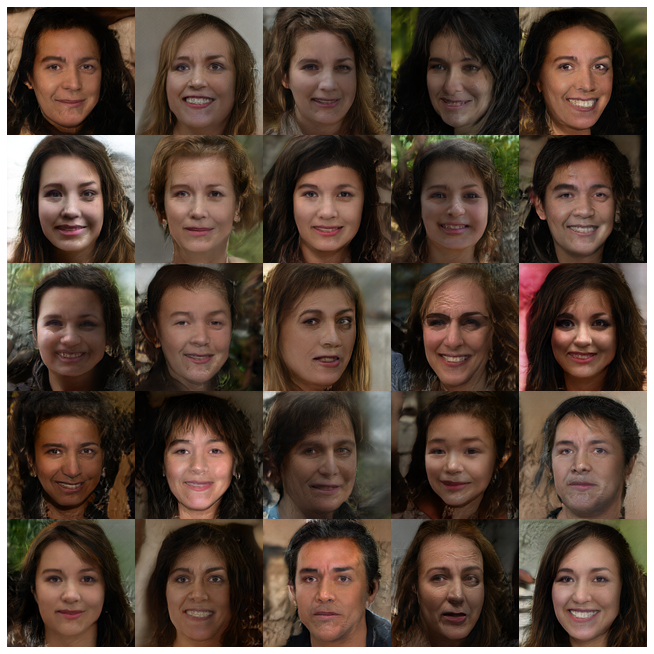

Time taken:  0:00:00.406296


In [10]:
dist = 5
samples = 25

a = datetime.datetime.now()
points = np.asarray([fastRandomPointFromDistance(np.asarray([0,0]), dist, 100) for i in range(samples)])

plot = generate_and_plot(generator, 100, points, samples)
b = datetime.datetime.now()

plt.show()


print("Time taken: ", b - a)

## Training of encoder

In [19]:
encoder = Encoder(128, 128, n_filters=64, pixel_depth=3, dataset_path=discriminator.dataset_path, dataset_type='face')
fmae = FMAE(encoder, generator, 128, 128, lr=0.0002)

In [ ]:
input_image, _ = encoder.generate_real_face_samples(12007, 1, dataset_path="dataset_download/thumbnails128x128")

fmae.train_fmae_on_dataset(input_image, 500, dataset_size=5000, batch_size=50, n_eval=20)

In [11]:
encoder.model.save_weights("saved_encoder")

In [65]:
encoder.model.load_weights("saved_encoder")

# Approximation of photo

Filename of input image (located in /gan): 00001.png
(128, 128, 3)


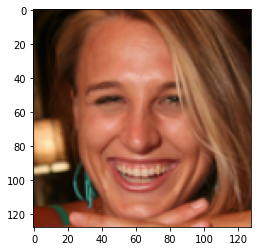

In [86]:
from autocrop import Cropper
cropper = Cropper(width=128, height=128, face_percent=55)

res = 128
filename = input("Filename of input image (located in /gan): ")
cropped_array = cropper.crop(filename)
print(cropped_array.shape)
fig = plt.imshow(cropped_array)
plt.show(fig)

#with Image.open(filename) as im:
#    resized_im = im.resize((res, res))
#    display(resized_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


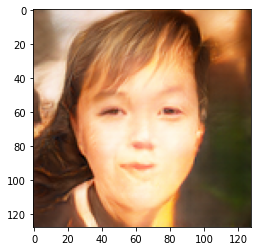

In [89]:
inp = np.asarray([cropped_array])

decoded_real_image = fmae.model.predict(inp)
fig = plt.imshow(decoded_real_image[0])
plt.show(fig)

Epoch 0


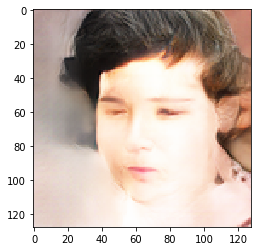

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100


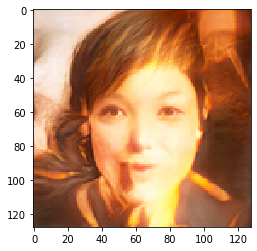

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 200


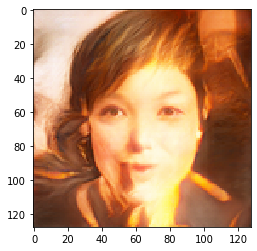

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 300


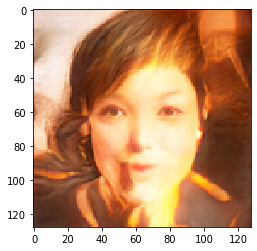

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 400


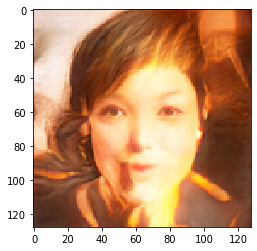

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 500


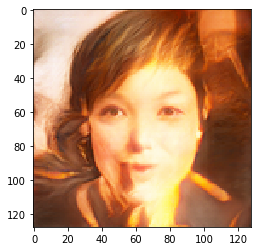

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 600


KeyboardInterrupt: 

In [82]:
fmae.train_fmae(np.asarray([cropped_array]), 10000)